In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np


In [2]:
load = torch.load('exercise3_stereo_pytorch.pth')
fixed = load['fixed'].unsqueeze(0)
moving = load['moving'].unsqueeze(0).unsqueeze(0)
data = load['data']

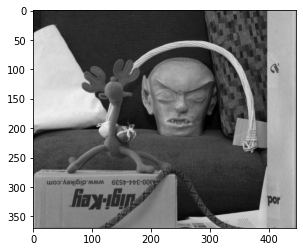

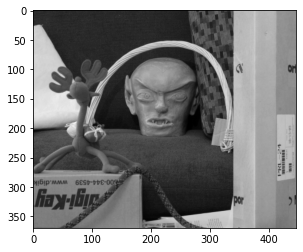

In [3]:
# visualize input data
plt.imshow(fixed.squeeze(0),'gray')
plt.show()
plt.imshow(moving.squeeze(),'gray')
plt.show()

In [4]:
# Aufgabe 1
small_dim = False
# wenn der Boolean gesetzt ist, kann eine Faltung nach dme unfolden durchgeführt werden,
# was ein deutlich glatteres Ergebnis liefert
unfold_bevore_gradient = False
if small_dim:
    H,W,K = 3,3,2
    moving = torch.arange(H * W, dtype=torch.float32).view(H,W).unsqueeze(0).unsqueeze(0)
    fixed = torch.arange(H * W, dtype=torch.float32).view(H,W).unsqueeze(0)

else:
    K = 67 # Number of possible Pixel disparities
    H, W = moving.shape[-2:]

weights_moving = torch.linspace(-0.5, 0.5, 3).repeat(1, K, 1, 1)
weights = torch.linspace(-0.5, 0.5, 3).view(1,1,1,3)

def compute_stereo_data_term(fixed, moving):
    beta = 0.11
    gamma = 7.0
    delta = 2.0

    # Bei dieser Variante wird erst unfoldest und dann auf dem unfoldeten der gradient gebildet
    if unfold_bevore_gradient:
        padded_moving = F.pad(moving, [K-1, 0]) # padded with 0 in x-direction
        unfolded_moving = F.unfold(padded_moving, (H,W))
        unfolded_moving = unfolded_moving.transpose(1, 2)# Bekommen genau die 67 möglichen patches
        unfolded_moving = unfolded_moving.view(K,H,W)

        unfolded_moving_gradient = F.conv2d(unfolded_moving.unsqueeze(0), weights_moving, padding=(0, 1)).squeeze(0).squeeze(0)
        fixed_gradient = F.conv2d(fixed.unsqueeze(0),weights,padding=(0, 1)).squeeze(0).squeeze(0)
    # Hier werden erst die Gracienten gebildet und danach wird das Bild unfoldet. Hier muss zweimal unfoldet werden.
    else:
        moving_gradient = F.conv2d(moving,weights,padding=(0, 1)).squeeze(0).squeeze(0)
        fixed_gradient = F.conv2d(fixed.unsqueeze(0),weights,padding=(0, 1)).squeeze(0).squeeze(0)

        padded_moving = F.pad(moving, [K-1, 0]) # padded with 0 in x-direction
        unfolded_moving = F.unfold(padded_moving, (H,W))
        unfolded_moving = unfolded_moving.transpose(1, 2)# Bekommen genau die 67 möglichen patches
        unfolded_moving = unfolded_moving.view(K,H,W)

        padded_moving_gradient = F.pad(moving_gradient, [K-1, 0]).unsqueeze(0).unsqueeze(0) # padded with 0 in x-direction
        unfolded_moving_gradient = F.unfold(padded_moving_gradient, (H,W))
        unfolded_moving_gradient = unfolded_moving_gradient.transpose(1, 2)# Bekommen genau die 67 möglichen patches
        unfolded_moving_gradient = unfolded_moving_gradient.view(K,H,W)

    # Faltung in x-Richtung. Achtung wir haben sogesehen 67 channel hier.
    # unfolded_moving_gradient = F.conv2d(unfolded_moving.unsqueeze(0), weights_moving, padding=(0, 1)).squeeze(0).squeeze(0)
    # fixed_gradient = F.conv2d(fixed.unsqueeze(0),weights,padding=(0, 1)).squeeze(0).squeeze(0)

    # Gleichung berechnen
    part_1 = beta * torch.clamp(torch.abs(fixed - unfolded_moving), max=gamma)
    part_2 = (1 - beta) *  torch.clamp(torch.abs(fixed_gradient - unfolded_moving_gradient), max = delta)


    return part_1 + part_2




D_y = compute_stereo_data_term(fixed, moving)

In [5]:
# Aufgabe 2 & 3

lecture = False
data_costs = torch.tensor(
                    [[0.5, 1.0, 3.0, 2.5, 1.5],
                     [3.0, 3.5, 1.5, 0.5, 2.0],
                     [2.0, 1.5, 1.0, 2.0, 4.0],
                     [2.0, 1.0, 3.0, 3.5, 1.0]])

def Viterbi(input_costs: torch.Tensor, K: int = 5, M: int = 0,
                       N: int = 4, max_regularizer = 100):

    # Initialize different pathes
    forward_path = torch.zeros_like(input_costs)
    backward_path = torch.zeros_like(input_costs)


    # Build reguliarizer matrix
    regularizer = torch.arange(K)
    regularizer_matrix = torch.stack([torch.clamp(torch.abs(regularizer - j).float(), max=max_regularizer) for j in range(K)])
    if M > 0: regularizer_matrix = regularizer_matrix.unsqueeze(2).repeat(1, 1, M)

    # compute forward pass
    for i in range(N):

        if i == 0:
            forward_path[:,:,i] = input_costs[:, :, i]
        else:
            past_path_matrix = forward_path[:, :, i-1] + regularizer_matrix
            past_path_matrix = torch.min(input=past_path_matrix,dim=1).values
            forward_path[:, :, i] = input_costs[:, :, i] + past_path_matrix

    # compute backward pass
    for i in range(N - 1, -1, -1):
        if i == N - 1:
            backward_path[:, :, i] = input_costs[:, :, i]
        else:
            past_path_matrix = backward_path[:, :, i+1] + regularizer_matrix
            past_path_matrix = torch.min(input=past_path_matrix,dim=1).values
            backward_path[:, :, i] = input_costs[:, :, i] + past_path_matrix

    return forward_path, backward_path



if lecture:
    # Aufgabe 2 --> Change Boolean lecture to true, and Loop index to [i] to compute data from lecture
    forward_path,backward_path = Viterbi(input_costs=data_costs)
    combined_costs = forward_path + backward_path - data_costs
    print('Computed Task 2:\n', combined_costs)
else:
    # Aufgabe 3 --> Change Boolean lecture to False, and Loop index to [:, :, i] to compute in image data
    k,m,n = D_y.shape
    forward_path, backward_path = Viterbi(input_costs=D_y,K=k,M=m,N=n,max_regularizer=3.5)
    combined_costs = forward_path + backward_path - D_y
    print('Computed Task 3')

Computed Task 3


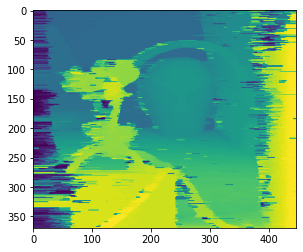

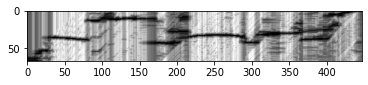

In [6]:
optimal_disparity= -torch.argmin(combined_costs, dim=0)
plt.imshow(optimal_disparity)
plt.show()

plt.imshow(combined_costs[:,200,:], cmap="gray")
plt.show()

/Users/falcolentzsch/.virtualenvs/FVMB/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/falcolentzsch/.virtualenvs/FVMB/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


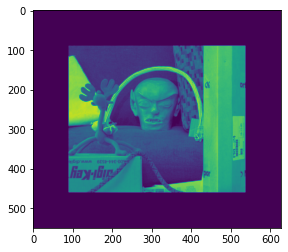

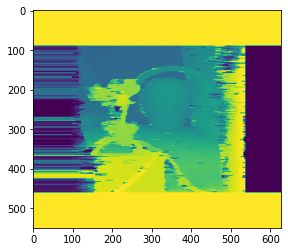

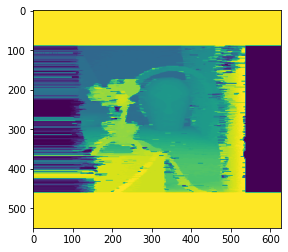

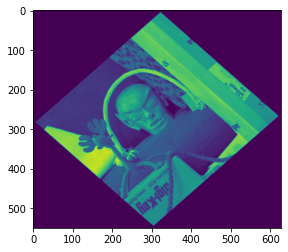

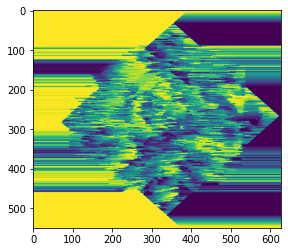

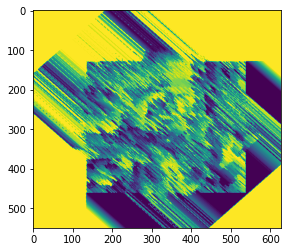

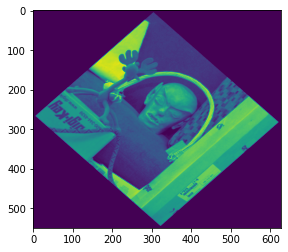

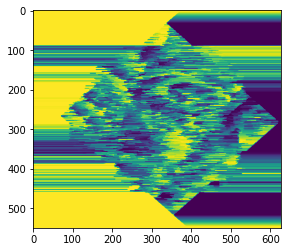

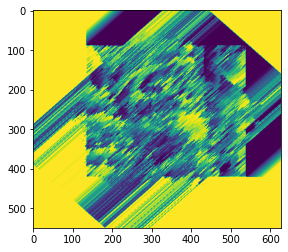

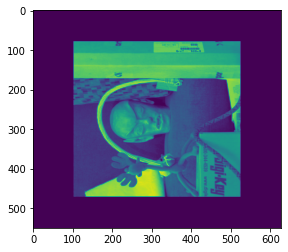

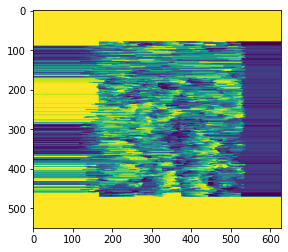

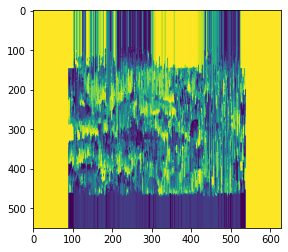

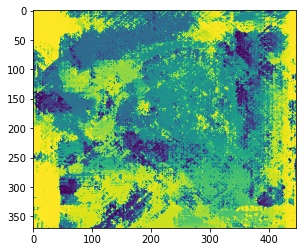

In [7]:
# Bonus Task
# Found some usefull functions here:
# https://stackoverflow.com/questions/64197754/how-do-i-rotate-a-pytorch-image-tensor-around-its-center-in-a-way-that-supports

# This functions creates the rotation matrix
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

# This functions applys the rotation on given input x
def rot_img(x, theta, dtype=torch.FloatTensor):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid, padding_mode="zeros")
    return x





# Bilder Padden, damit wir keine Informationen verlieren
pad_size = 90
padded_moving = F.pad(moving,[pad_size, pad_size, pad_size, pad_size])
padded_fixed = F.pad(fixed,[pad_size, pad_size, pad_size, pad_size])

# Bonus-Aufgabe
angle = [0, np.pi/4, -np.pi/4, np.pi/2]
angle_4 = [0, np.pi/2]
H, W = padded_moving.shape[-2:]
sgm_combined_costs = torch.zeros(K,H,W)

for i in angle:
    pad_rotated_moving = rot_img(padded_moving, i)
    plt.imshow(pad_rotated_moving.squeeze())
    plt.show()
    D_y = compute_stereo_data_term(fixed=padded_fixed, moving=pad_rotated_moving)
    k,m,n = D_y.shape
    forward_path, backward_path = Viterbi(input_costs=D_y,K=k,M=m,N=n,max_regularizer=3.5)

    # Only to visualize cost befor rotation
    rotated_combined_costs = forward_path + backward_path - D_y
    visualize_rotated_combined_costs = -torch.argmin(rotated_combined_costs, dim=0)
    plt.imshow(visualize_rotated_combined_costs)
    plt.show()

    # Only to visualize cost after rotation
    combined_costs = rot_img(rotated_combined_costs.unsqueeze(0), -i)
    visualize_combined_costs = -torch.argmin(combined_costs.squeeze(0), dim=0)
    plt.imshow(visualize_combined_costs)
    plt.show()


    sgm_combined_costs += combined_costs.squeeze(0)

cropped_sgm = sgm_combined_costs[:,pad_size:H-pad_size,pad_size:W-pad_size]
optimal_disparity= -torch.argmin(cropped_sgm, dim=0)
plt.imshow(optimal_disparity)
plt.show()